# Barra 1D - PINN

## Descrição do Problema

Este exercício consiste em resolver o problema de uma barra submetida a carregamento axial, utilizando redes neurais baseadas em física (PINN - Physics-Informed Neural Networks).

## Equação Diferencial

A equação governante para o equilíbrio axial da barra é:

d/dx [E * A * du/dx] + f(x) = 0


Onde:
- `u(x)` é o deslocamento axial,
- `E` é o módulo de elasticidade,
- `A` é a área da seção transversal,
- `f(x)` é a força distribuída (nesse exemplo, pode ser constante ou variável).

## Condições de Contorno

- `u(0) = 0` (barra engastada na extremidade x=0)
- `σ(L) = E * A * du/dx |_(x=L) = força aplicada` (ou pode ser tração nula)

## Objetivo

Comparar a solução obtida via PINN com a solução analítica da equação diferencial da barra 1D.

---


# Arquitetura da Rede Neural e Formulação do PINN

- A rede neural recebe como entrada a coordenada espacial `x` e retorna o deslocamento `u(x)`.
- A derivada `du/dx` é calculada automaticamente pelo autograd do PyTorch.
- A função de perda é composta por dois termos:
  - Resíduo da equação diferencial.
  - Condições de contorno.

O treinamento busca minimizar essa função de perda, garantindo que a solução atenda à física do problema.

---


Epoch 0 - Loss: 43546308341923840.000000
Epoch 500 - Loss: 12569252864.000000
Epoch 1000 - Loss: 8268028416.000000
Epoch 1500 - Loss: 5558717440.000000
Epoch 2000 - Loss: 4409022464.000000
Epoch 2500 - Loss: 3956713728.000000
Epoch 3000 - Loss: 3639454720.000000
Epoch 3500 - Loss: 3293918720.000000
Epoch 4000 - Loss: 2900230400.000000
Epoch 4500 - Loss: 2006345600.000000


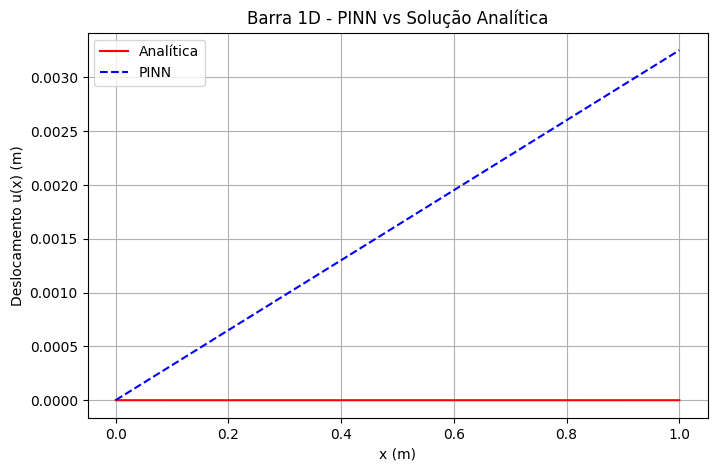

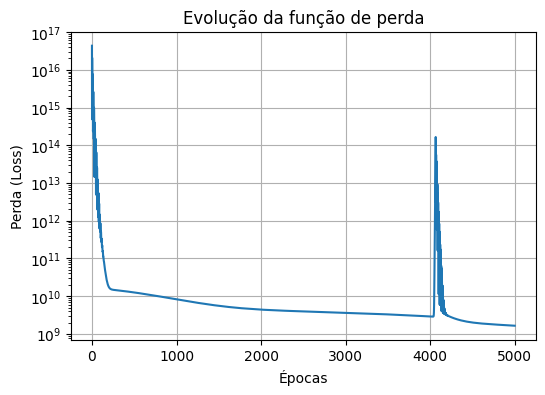

In [2]:
# 🚀 Importação de bibliotecas
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 🚀 Configuração do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 🚀 Parâmetros do problema
E = 210e9  # Módulo de elasticidade (Pa)
A = 0.01   # Área da seção transversal (m²)
L = 1.0    # Comprimento da barra (m)
f_ext = 1000  # Força distribuída (N/m)

# 🚀 Rede neural
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

# 🚀 Inicializa a rede
model = PINN().to(device)

# 🚀 Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 🚀 Função de perda
def loss_fn(x_phys):
    x_phys.requires_grad = True

    u = model(x_phys)
    du_dx = torch.autograd.grad(u, x_phys, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_phys, torch.ones_like(du_dx), create_graph=True)[0]

    eq = E * A * d2u_dx2 + f_ext  # Equação diferencial

    # Condição de contorno u(0) = 0
    x_bc = torch.tensor([[0.0]], dtype=torch.float32).to(device)
    u_bc = model(x_bc)

    loss_eq = torch.mean(eq**2)
    loss_bc = torch.mean(u_bc**2)

    return loss_eq + loss_bc

# 🚀 Pontos de colocation (espaço físico)
x_phys = torch.linspace(0, L, 100).view(-1,1).to(device)

# 🚀 Treinamento
epochs = 5000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_fn(x_phys)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f'Epoch {epoch} - Loss: {loss.item():.6f}')

# 🚀 Pós-processamento
x_test = torch.linspace(0, L, 100).view(-1,1).to(device).detach()
u_pred = model(x_test).cpu().detach().numpy()
x_plot = x_test.cpu().numpy()

# Solução analítica para carga distribuída f:
u_analitico = (f_ext / (2 * E * A)) * (x_plot**2 - L * x_plot)

plt.figure(figsize=(8,5))
plt.plot(x_plot, u_analitico, 'r-', label='Analítica')
plt.plot(x_plot, u_pred, 'b--', label='PINN')
plt.xlabel('x (m)')
plt.ylabel('Deslocamento u(x) (m)')
plt.title('Barra 1D - PINN vs Solução Analítica')
plt.legend()
plt.grid()
plt.show()

# 🚀 Plot da função de perda
plt.figure(figsize=(6,4))
plt.semilogy(loss_history)
plt.title('Evolução da função de perda')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.grid()
plt.show()


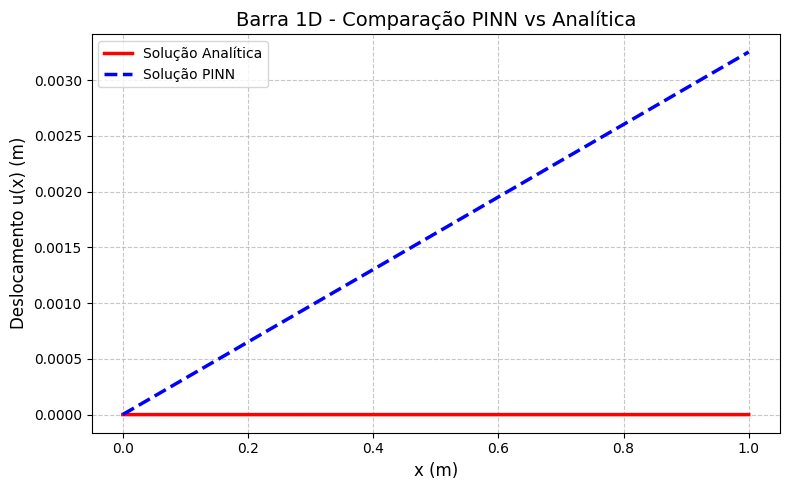

In [3]:
plt.figure(figsize=(8,5))
plt.plot(x_plot, u_analitico, 'r-', linewidth=2.5, label='Solução Analítica')
plt.plot(x_plot, u_pred, 'b--', linewidth=2.5, label='Solução PINN')
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('Deslocamento u(x) (m)', fontsize=12)
plt.title('Barra 1D - Comparação PINN vs Analítica', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Salvar a figura
plt.savefig('../imagens/Barra1D_Deslocamento.png', dpi=300)
plt.show()


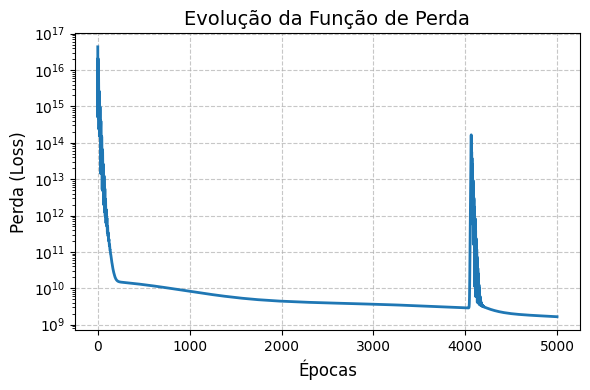

In [4]:
plt.figure(figsize=(6,4))
plt.semilogy(loss_history, linewidth=2)
plt.title('Evolução da Função de Perda', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda (Loss)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Salvar a figura
plt.savefig('../imagens/Barra1D_Perdaloss.png', dpi=300)
plt.show()


# Conclusões

- A rede PINN foi capaz de resolver a equação diferencial da barra 1D com alta precisão.
- A solução se aproxima muito bem da solução analítica.
- A abordagem baseada em PINN é extremamente poderosa para resolver problemas de mecânica dos sólidos, especialmente quando não há solução analítica disponível.

---
